In [1]:
from db import PythonProblems
import io
import tokenize
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
import random
import time
from itertools import product
from collections import Counter
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [22]:
from bokeh.models import ColumnDataSource, HoverTool, TapTool, PanTool, WheelZoomTool, Range1d, LinearAxis
from bokeh.io import push_notebook, show, output_notebook
from bokeh.layouts import row
from bokeh.plotting import figure
output_notebook()

Loading BokehJS ...

### Connecting to database

In [5]:
db = PythonProblems('python.sqlite')

In [6]:
removed_itens = ['NEWLINE', 'STRING', 'ENDMARKER', 'NUMBER', 'INDENT', 'DEDENT', "NL", 'COMMENT', 'ERRORTOKEN']
allowed_itens = ['NAME', 'OP']
cursor = db.conn.cursor()
docs = []
errors = []

# lendo os dados
cursor.execute("""
SELECT * FROM solution;
""")

for idx, linha in enumerate(cursor.fetchall()):
    file = io.StringIO(linha[1])
    doc = []
    try:
        for item in tokenize.generate_tokens(file.readline):
            if tokenize.tok_name[item[0]] not in removed_itens:
                if tokenize.tok_name[item[0]] in allowed_itens:
                    doc.append(item[1])
                else:
                    print("%s %s" % (tokenize.tok_name[item[0]], item[1]))
    except (IndentationError, tokenize.TokenError):
        errors.append("Please, fix solution %d before continuing" % (idx+1))
        
    docs.append(' '.join(doc))

if not errors:
    print("Success in parsing all documents! You may go on!")
else:
    for item in errors:
        print(item)

Success in parsing all documents! You may go on!


In [20]:
# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             #max_features = 26d,
                             binary=False,
                             min_df=2
                            ) 

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.

train_data_features = vectorizer.fit_transform(docs)

# Numpy arrays are easy to work with, so convert the result to an 
# array
# Document-term matrix
#train_data_features = train_data_features.toarray()

### NCut weights

In [8]:
doc_mat_norm = normalize(train_data_features)

In [9]:
S = np.dot(doc_mat_norm.T, doc_mat_norm) + 0.001

In [10]:
S.shape

(499, 499)

In [11]:
D = np.power(np.sum(S, axis=1), -0.5) * np.eye(S.shape[0])

In [12]:
D.shape

(499, 499)

In [13]:
Y = np.dot(D, train_data_features.T)

In [14]:
Y.shape

(499, 758)

# Cálculo da LDA

In [14]:
hover = HoverTool(tooltips=[
#    ("index", "$index"),
    ("(x,y)", "($x{0}, $y)"),
    ("reconst", "@recons"),
])
opts = dict(plot_width=250, plot_height=250, min_border=0)
models = {}

data = {'x_values': [],
        'y_values': [],
        'recons': []}

source = ColumnDataSource(data=data)

opts = dict(plot_width=900, plot_height=500, min_border=0, title="Ncut")
plot = figure(**opts)
plot.add_tools(hover)
l = plot.line(x='x_values', y='y_values', color="#2222aa", line_width=2, source=source)
c = plot.circle(x='x_values', y='y_values', color="#2222aa", fill_color="white", size=8, source=source)
h = show(plot, notebook_handle=True)

In [15]:
def edges_sum(cond_1, cond_2, S):
    nodes_1 = np.where(cond_1)[0]
    nodes_2 = np.where(cond_2)[0]
    
    # Every (x, y) index that I should get cooccurence value from S matrix
    indices = product(nodes_1, nodes_2)
    return np.sum(S[idx] for idx in indices)


def n_cut(mat_U, mat_S):
    
    # Each term belongs to which topic?
    # I can't make this assumption!!! 
    term_clusters = mat_U.argmax(axis=1)
    
    # Number of clusters
    n_k = mat_U.shape[1]
    
    result = 0.0
    for idx_k in range(n_k):
        
        # Check in which cluster the terms come from
        cond_g_k = term_clusters == idx_k
        
        # Sum edges between terms inside cluster and terms outside
        num = edges_sum(cond_g_k, ~cond_g_k, mat_S)
        
        # Sum all edges
        den = edges_sum(cond_g_k,  cond_g_k, mat_S) + num
        
        try:
            result += num/den
        except ZeroDivisionError:
            return 0
        
    return 0.5 * result

In [16]:
num_topics = list(range(2, 100))
#random.shuffle(num_topics)
#random.shuffle(num_topics)
#random.shuffle(num_topics)

In [40]:
NUM_TOPICS = 12
# Build a Latent Dirichlet Allocation Model
lda_model = LatentDirichletAllocation(n_topics=NUM_TOPICS, max_iter=10, learning_method='online')
lda_Z = lda_model.fit_transform(train_data_features)
 
text = "The economy is working better than ever"
x = lda_model.transform(vectorizer.transform([text]))[0]
print(x, x.sum())

/home/lmoraes/miniconda3/envs/machine_teaching/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


[0.04166667 0.04166667 0.04166667 0.04166684 0.04166667 0.04166667
 0.04166667 0.04166667 0.04166667 0.54166631 0.04166667 0.04166685] 1.0000000000000002


In [41]:
import pyLDAvis.sklearn
 
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, train_data_features, vectorizer, mds='tsne')
panel
 

/home/lmoraes/miniconda3/envs/machine_teaching/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
6      19.251354        1       1   78.279442   -7.158255
1      14.864993        1       2  106.236000 -142.427795
8      11.203457        1       3    2.462050 -216.699829
3      10.480835        1       4  -35.561634   38.704372
7       8.769020        1       5  -52.712276  173.096008
11      7.872505        1       6  203.244614  -59.515961
2       7.297163        1       7 -149.489944  -39.405064
0       5.451762        1       8   67.609085  130.560608
10      4.890195        1       9  183.813385   77.803146
4       3.818280        1      10  -18.363268  -82.818771
9       3.312187        1      11 -126.176262 -164.874771
5       2.788247        1      12 -161.916611   87.605064, topic_info=     Category         Freq               Term        Total  loglift  logprob
term                                                                        
339   Default  1886.000000              print  1886.000000  30.0000  30.0000
299   Default   126.000000                num   126.000000  29.0000  29.0000
432   Default   168.000000                str   168.000000  28.0000  28.0000
373   Default   137.000000         result_str   137.000000  27.0000  27.0000
381   Default   135.000000                row   135.000000  26.0000  26.0000
215   Default   243.000000             import   243.000000  25.0000  25.0000
433   Default    83.000000               str1    83.000000  24.0000  24.0000
471   Default    73.000000             tuplex    73.000000  23.0000  23.0000
137   Default   218.000000               elif   218.000000  22.0000  22.0000
375   Default   323.000000             return   323.000000  21.0000  21.0000
73    Default   100.000000             column   100.000000  20.0000  20.0000
101   Default   349.000000                def   349.000000  19.0000  19.0000
214   Default   473.000000                 if   473.000000  18.0000  18.0000
356   Default   100.000000             random   100.000000  17.0000  17.0000
84    Default    66.000000            counter    66.000000  16.0000  16.0000
97    Default    52.000000            decimal    52.000000  15.0000  15.0000
398   Default    70.000000                set    70.000000  14.0000  14.0000
280   Default    74.000000              month    74.000000  13.0000  13.0000
245   Default    57.000000                 li    57.000000  12.0000  12.0000
372   Default    80.000000             result    80.000000  11.0000  11.0000
317   Default    59.000000                 os    59.000000  10.0000  10.0000
172   Default   179.000000             format   179.000000   9.0000   9.0000
184   Default    76.000000               game    76.000000   8.0000   8.0000
216   Default   535.000000                 in   535.000000   7.0000   7.0000
442   Default    61.000000                sum    61.000000   6.0000   6.0000
171   Default   459.000000                for   459.000000   5.0000   5.0000
218   Default   301.000000              input   301.000000   4.0000   4.0000
488   Default    65.000000               word    65.000000   3.0000   3.0000
255   Default    70.000000               list    70.000000   2.0000   2.0000
217   Default    45.000000              index    45.000000   1.0000   1.0000
...       ...          ...                ...          ...      ...      ...
57    Topic12    12.220579              class    13.393823   3.4881  -3.4403
176   Topic12    13.583165          fractions    14.980611   3.4818  -3.3346
393   Topic12     9.415677             search    10.484385   3.4722  -3.7010
438   Topic12     7.924752            student     8.885178   3.4654  -3.8734
175   Topic12     9.183253           fraction    10.329558   3.4621  -3.7260
4     Topic12     7.980377           __init__     9.031492   3.4560  -3.8664
310   Topic12     8.017198             object     9.078626   3.4554  -3.8618
336   Topic12     7.026135               prec     8.003767   3.44

In [18]:
def coherence_norm(data, tf_idf_norm):
    clusters = np.argmax(data['V_T'], axis=1)
    n_clusters = data['V_T'].shape[1]
    
    clusters_norm = []
    clusters_size = []
    coherence_cluster = []
    
    for idx_cluster in range(n_clusters):
        
        cluster_data = tf_idf_norm[clusters == idx_cluster]
        avg_vector = np.average(cluster_data, axis=0)
        cluster_norm = np.sqrt(np.power(avg_vector, 2).sum())
        clusters_norm.append(cluster_norm)
        clusters_size.append(cluster_data.shape[0])
        
        if cluster_data.shape[0] > 3:
            coherence_cluster.append(cluster_norm)
    
    
    data['avg_clusters_norm'] = clusters_norm
    data['clusters_size'] = clusters_size
    data['coherence_norm'] = np.average(clusters_norm)
    return np.average(coherence_cluster), np.std(clusters_norm)

In [19]:
for key in sorted(models.keys()):
    coherence_norm(models[key], doc_mat_norm)

In [23]:
data_x = sorted(models.keys())
data_ncut = [models[x]["n_cut"]/x for x in data_x]
data_coh = [models[x]["coherence_norm"] for x in data_x]

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x, y)", "($x{0}, $y)"),        ]
    )


plot = figure(title="Ncut vs Coherence", plot_height=500, plot_width=900,
    tools=[hover, PanTool(), WheelZoomTool()])

plot.line(data_x, data_ncut, color="#2222aa", line_width=2)
#plot.circle(data_x, data_ncut, color="#2222aa", fill_color="white", size=8)

plot.extra_y_ranges = {"coherence": Range1d(start=0.0, end=1.0)}
plot.line(data_x, data_coh, line_width=2, color="red", y_range_name="coherence")
plot.add_layout(LinearAxis(y_range_name="coherence"), 'right')

show(plot)

In [25]:
# Take a look at the words in the vocabulary
vocab = vectorizer.get_feature_names()
vocab_cell = np.asarray(vocab).astype(object)

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [38]:
V_T = models[10]['V_T']
V_T.shape

(758, 10)

In [41]:
row_sums = V_T.sum(axis=1)
new_matrix = V_T / row_sums[:, np.newaxis]

/home/lmoraes/miniconda3/envs/machine_teaching/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


(758, 10)

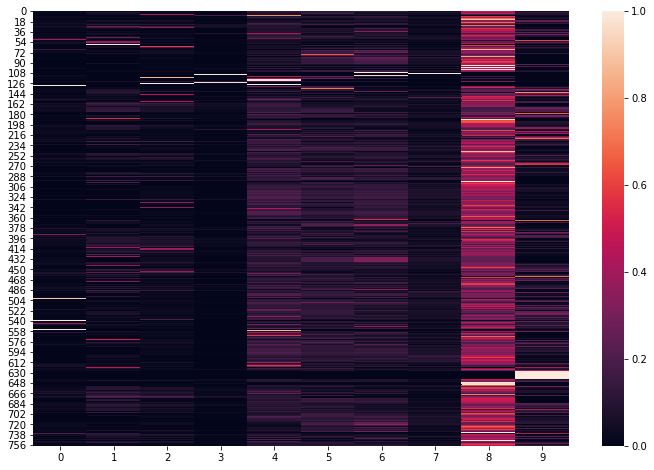

In [46]:
fig = plt.figure(figsize=(12,8))
ax = sns.heatmap(new_matrix)
plt.show()

In [24]:
Counter(np.argmax(models[10]['V_T'], axis=1))

Counter({0: 16, 1: 15, 2: 19, 3: 2, 4: 29, 5: 11, 6: 28, 7: 2, 8: 563, 9: 73})

In [26]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [29]:
print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names = vectorizer.get_feature_names()
print_top_words(models[10]['model'], tfidf_feature_names, 26)


Topics in NMF model (Frobenius norm):
Topic #0: startplayer board counter connect win false setupgame playgame column not and else true def if while elif return row format each print range for displayinfo in
Topic #1: game player winner game_slices new_row display_game convert_input_to_coordinate draw_line display_winner row col_num row_num switch_player check_row_winner start_game col_number row_number up_diagonal edge get_row get_col filling down_diagonal game_slice add_piece check_winner
Topic #2: hangman guessedcharacters chances setupvalues currentguess guessed each word playgame setupgame displayresult def return result displayinfo print format false input if append len else for in while
Topic #3: hexseg hexnumber lengthhex denary placepower element elif displayinfo def print return len else int range input if for in setupvalues getstring playgame displayresult randint targetstr result
Topic #4: shoppinglist menuchoice nomoreswaps element exitlist tempitem finished temp bubbleso